In [23]:
# Import libraries
#   File management
from tkinter import filedialog  # For selecting files
import os  # For directory management
import glob
import shutil
#   Number, file, and image management
import cv2  # Computer vision/image processing
from scipy.ndimage import label
from skimage import measure, util
import seaborn as sns
from sklearn.model_selection import train_test_split  # For machine learning approach
from sklearn.neighbors import KNeighborsClassifier  # ""
from sklearn.linear_model import LogisticRegression  # " "
from sklearn.metrics import confusion_matrix  # " "
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score  # " "
import numpy as np  # For array management
import pandas as pd  # For database management
import random
from pandas import Series
#   Plotting results
import matplotlib.pyplot as plt  # For plotting result data
import matplotlib.patches as mpatches  # For keys

In [24]:
# Provide pathways to:

# 1. Sheet with all classifications, with classifications from each scan on a different sheet
class_sheet = '/path to/TRAIN7.xlsx'

# 2. Directory of excel files, with data from each scan represented within a different excel sheet
quant_folder = '/path to/TRAINall'

# Sheet names and corresponding excel file fraddl_scan_path = '/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/Validation/X-16W KO11_Scan1.qptiff - resolution #1/Numerical analysis'ames must match exactly

os.chdir(os.path.dirname(class_sheet))

In [25]:
# Make a list of excel files
# When making the list of excel files, ensure no files are currently open (will see $ describing file names)
names = sorted(glob.glob(quant_folder + '/*.xlsx'))
print(names)

['/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/New tiles for classification/DATAr/16WCTL4.xlsx', '/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/New tiles for classification/DATAr/CB.xlsx', '/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/New tiles for classification/DATAr/CTL1.xlsx', '/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/New tiles for classification/DATAr/CTL6.xlsx', '/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/New tiles for classification/DATAr/KO1.xlsx', '/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/New tiles for classification/DATAr/KO5.xlsx', '/Users/dominickhellen/Documents/Karpen Lab/Machine Learning/New tiles for classification/DATAr/P30BDL.xlsx']


In [26]:
# Create test/train data by appending features to classified events

# Combine all data into one large data frame
df = pd.DataFrame()

for filename in names:
    
    # Read excel file and add scan name
    excel = pd.read_excel(filename, engine='openpyxl')
    scan_name = os.path.basename(filename).split('.')[0]
    excel['Scan'] = scan_name
    
    # Read corresponding sheet on class file, add additional NaN elements to match length of dataframe, and append
    classes = pd.read_excel(class_sheet, sheet_name=scan_name, engine='openpyxl')
    
    n_events = len(excel)
    n_classes = len(classes)
    
    class_vector = classes['Class'].tolist() + [np.nan]*(n_events - n_classes)  # Will convert to categorical
    
    excel['Class'] = class_vector
    
    df = df.append(excel, ignore_index=True)

In [27]:
df.head()

,Image,Index,Area,Eccentricity,Min. axis,Major axis,Solidity,Perimeter,Extent,Euler,feret_diameter_max,Scan,Class
0,CTL 4,Scan1.qptiff - resolution #1,539.0,0.772079,30.935741,48.677353,0.375610,271.267027,0.267361,0,57.489129,16WCTL4,dp
1,CTL 4,Scan1.qptiff - resolution #1,575.0,0.987372,17.060276,107.691301,0.387205,306.302561,0.225667,-1,98.005102,16WCTL4,dp
2,CTL 4,Scan1.qptiff - resolution #1,404.0,0.960873,19.119818,69.027452,0.372694,168.089358,0.221978,1,66.490601,16WCTL4,dp
3,CTL 4,Scan1.qptiff - resolution #1,96.0,0.690870,10.972314,15.176531,0.721805,46.349242,0.492308,1,15.811388,16WCTL4,sc
4,CTL 4,Scan1.qptiff - resolution #1,1090.0,0.968300,24.405340,97.702910,0.563599,400.599026,0.298222,-2,93.107465,16WCTL4,cb


In [28]:
# Clean test/train data dataframe
df = df.fillna('0')  # Replace nan with element easier to excel
df_for_model = df[df['Class'] != '0']
print(len(df_for_model))

# Are labels consistent?
print(df_for_model['Class'].unique())

# Clean up as necessary
df_for_model = df_for_model.replace('m ', 'm')
df_for_model = df_for_model.replace('c', 'cb')
print(df_for_model['Class'].unique())

5255
['dp' 'sc' 'cb' 'm']
['dp' 'sc' 'cb' 'm']


In [29]:
# How many of each label is present?
print(df_for_model['Class'].value_counts(), '\n')

sc    2732
dp    1609
cb     657
m      257
Name: Class, dtype: int64 



In [30]:
# Select only relevant columns
df_for_model = df_for_model[['Area', 'Extent', 'Solidity', 'Perimeter', 'Euler', 'feret_diameter_max', 'Eccentricity', 'Min. axis', 'Major axis', 'Scan', 'Class']]

In [31]:
# Create a dataframe of all other data for future classification
df_for_quant = df[df['Class'] == '0']
df_for_quant.head()
print(len(df_for_quant))

5016


In [32]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

In [33]:
# Data preparation for machine learning - create an X block (features) and a y block (classes)
X_v3 = df_for_model.drop(['Scan','Major axis', 'Class','Min. axis', 'Perimeter', 'Extent', 'feret_diameter_max'], axis = 1)
print(X_v3.head(3), '\n')

X_v3_feature_names = X_v3.columns

y = df_for_model.loc[:, 'Class']
target_class = 'cb'
y1 = df_for_model[df_for_model['Class'] == target_class]
print(y.head(10))

    Area  Solidity  Euler  Eccentricity
0  539.0  0.375610      0      0.772079
1  575.0  0.387205     -1      0.987372
2  404.0  0.372694      1      0.960873 

0    dp
1    dp
2    dp
3    sc
4    cb
5    sc
6     m
7    sc
8    sc
9    sc
Name: Class, dtype: object


In [34]:
X_v3_rs, y_v3_rs = oversample.fit_resample(X_v3, y)
print('Original length: ' + str(len(X_v3)))
print('New length: ' + str(len(X_v3_rs)))

Original length: 5255
New length: 10928


In [35]:
# Split data into train and test data
X_v3_train, X_v3_test, y_v3_train, y_v3_test = train_test_split(X_v3_rs, y_v3_rs, random_state = 10)
print('Training data length is: ' + str(len(X_v3_train)))
print('Testing data length is: ' + str(len(X_v3_test)))

Training data length is: 8196
Testing data length is: 2732


In [36]:
from sklearn.ensemble import GradientBoostingClassifier
clf_BT = GradientBoostingClassifier()
clf_BT.fit(X_v3_train, y_v3_train)  # Fit model
prediction_BT = clf_BT.predict(X_v3_test)  # Generate predictions on test data

In [37]:
# Precision, recall
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_v3_test, prediction_BT)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.8042328  0.80732484 0.98219585 0.87388724]
recall: [0.87734488 0.71813031 0.99101796 0.88571429]
fscore: [0.83919945 0.76011994 0.98658718 0.87976102]


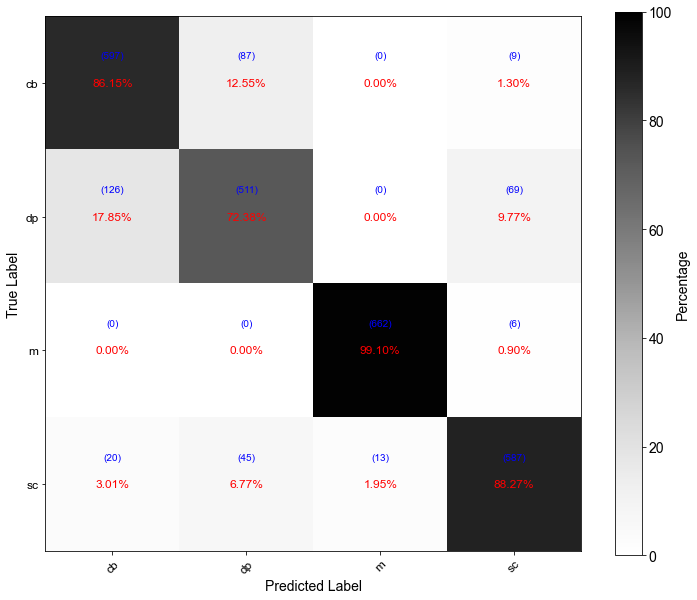

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have defined `y_v3_test` and `prediction_BT` earlier
labels = np.unique(np.concatenate((y_v3_test, prediction_BT)))  # Get unique labels

cm = confusion_matrix(y_v3_test, prediction_BT)

# Calculate confusion matrix percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 10))

font = {'family': 'Arial', 'size': 14}
plt.rc('font', **font)

plt.imshow(cm_percent, cmap='Greys', vmin=0, vmax=100)  # Adjust the colormap and limits
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(np.arange(len(labels)), labels, fontsize=12, rotation=45)
plt.yticks(np.arange(len(labels)), labels, fontsize=12)

# Annotate cells with the confusion matrix percentages and actual labels
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, f'{cm_percent[i, j]:.2f}%', ha='center', va='center', fontsize=12, color='red')
        plt.text(j, i - 0.2, f'({cm[i, j]})', ha='center', va='center', fontsize=10, color='blue')

plt.colorbar(label='Percentage')

plt.savefig("confusion_matrix_with_labels.png", bbox_inches='tight', dpi=300)

plt.show()


In [114]:
addl_scan_path = '/Users/dominickhellen/Downloads/heat map trial/tiles/ctls/c14'
addl_scan_names = sorted(glob.glob(addl_scan_path + '/*.xlsx'))
print(addl_scan_names)

['/Users/dominickhellen/Downloads/heat map trial/tiles/ctls/c14/N-30 CTL 14_Scan1.qptiff - resolution #1.xlsx']


In [115]:
import pandas as pd
import os
from collections import Counter

df_count = pd.DataFrame()
df_percent = pd.DataFrame()
mean_area_all_scans = pd.DataFrame(columns=['Scan', 'Class assigned', 'Mean Area'])


# Assuming you have a list of filenames in 'addl_scan_names'
for filename in addl_scan_names:
    scan = os.path.basename(filename).split('.')[0]
    print(scan)
    
    # Read excel file and add scan name
    excel = pd.read_excel(filename, engine='openpyxl')

    df_scan_X = excel[['Area', 'Solidity', 'Euler', 'Eccentricity']]
    prediction_quant = clf_BT.predict(df_scan_X)

    # Count number of predicted classes
    c = Counter(prediction_quant)
    print('Raw count')
    raw_df = pd.DataFrame.from_dict([(i, c[i]) for i, count in c.most_common()])
    raw_df['Scan'] = scan
    print(raw_df)  # Not debugged
    df_count = df_count.append(raw_df, ignore_index=True)
    print('Percent')
    per_df = pd.DataFrame.from_dict([(i, c[i] / len(prediction_quant) * 100.0) for i, count in c.most_common()])
    per_df['Scan'] = scan
    print(per_df)  # Not debugged
    df_percent = df_percent.append(per_df, ignore_index=True)

    # Print mean values per class
    df_scan_X['Class assigned'] = prediction_quant
    class_means = df_scan_X.groupby(['Class assigned'])['Area', 'Solidity', 'Euler', 'Eccentricity'].mean()
    print("Mean Area per Class:")
    print(class_means)
    
    # Append the mean area data for the current scan to the DataFrame
    mean_area_data_scan = class_means.reset_index()
    mean_area_data_scan['Scan'] = scan
    mean_area_all_scans = mean_area_all_scans.append(mean_area_data_scan, ignore_index=True)


N-30 CTL 14_Scan1
Raw count
    0     1               Scan
0  sc  1113  N-30 CTL 14_Scan1
1  dp   562  N-30 CTL 14_Scan1
2  cb   170  N-30 CTL 14_Scan1
3   m   166  N-30 CTL 14_Scan1
Percent
    0          1               Scan
0  sc  55.345599  N-30 CTL 14_Scan1
1  dp  27.946295  N-30 CTL 14_Scan1
2  cb   8.453506  N-30 CTL 14_Scan1
3   m   8.254600  N-30 CTL 14_Scan1
Mean Area per Class:
                       Area  Solidity     Euler  Eccentricity
Class assigned                                               
cb              2234.400000  0.640202 -3.082353      0.729673
dp              1024.519573  0.519340 -0.960854      0.904029
m                 26.367470  0.776125  1.000000      0.909764
sc               168.794250  0.618607  0.781671      0.836899


<ipython-input-115-a95d99f69e46>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scan_X['Class assigned'] = prediction_quant
<ipython-input-115-a95d99f69e46>:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  class_means = df_scan_X.groupby(['Class assigned'])['Area', 'Solidity', 'Euler', 'Eccentricity'].mean()


In [116]:
# Only run this code if working with spatial remapping

import os
import pandas as pd

df_count = pd.DataFrame()
df_percent = pd.DataFrame()

for filename in addl_scan_names:
    
    scan = os.path.basename(filename).split('.')[0]
    
    print(scan)
    
    # Read excel file and add scan name
    excel = pd.read_excel(filename, engine='openpyxl')

    # Extract the 'Centroid' column
    df_scan_X = excel[['Image','Centroid','x_coord','y_coord']]
    df = pd.DataFrame(df_scan_X)
    df['SmallX'], df['SmallY'] = zip(*df['Centroid'].str.strip('()').str.split(', '))
    
    df['BigX'] = df['Image'].str.extract(r'x=(\d+)').astype(int) * 0.5
    df['BigY'] = df['Image'].str.extract(r'y=(\d+)').astype(int) * 0.5

    df['SmallX'] = df['SmallX'].astype(float) * 0.5
    df['SmallY'] = df['SmallY'].astype(float) * 0.2
    
    df['medX'] = df['x_coord'].astype(int) * 0.5
    df['medY'] = df['y_coord'].astype(int) * 0.5
    
    
    df['X'] = df['BigX'].astype(int) + df['SmallX'] + df['medX']
    df['Y'] = df['BigY'].astype(int) + df['SmallY'] + df['medY']
    
    # Display the resulting dataframe
    print(df)


N-30 CTL 14_Scan1
                                                  Image  \
0     Scan1.qptiff - resolution #1 [x=10240,y=15360,...   
1     Scan1.qptiff - resolution #1 [x=10240,y=15360,...   
2     Scan1.qptiff - resolution #1 [x=10240,y=15360,...   
3     Scan1.qptiff - resolution #1 [x=10240,y=15360,...   
4     Scan1.qptiff - resolution #1 [x=10240,y=15360,...   
...                                                 ...   
2006  Scan1.qptiff - resolution #1 [x=5120,y=35840,w...   
2007  Scan1.qptiff - resolution #1 [x=5120,y=35840,w...   
2008  Scan1.qptiff - resolution #1 [x=5120,y=35840,w...   
2009  Scan1.qptiff - resolution #1 [x=5120,y=35840,w...   
2010  Scan1.qptiff - resolution #1 [x=5120,y=35840,w...   

                                      Centroid  x_coord  y_coord     SmallX  \
0     (18.529411764705884, 18.776470588235295)     1054      750   9.264706   
1     (14.975609756097562, 24.048780487804876)     1398      793   7.487805   
2     (15.978571428571428, 24.835714

In [70]:
# Write these values to an excel sheet

# Set up excel sheet
writer = pd.ExcelWriter('P5k19final.xlsx', engine='openpyxl')  # To write excel sheets

# Save sheets
df_count.to_excel(writer, sheet_name='Counts, additional scans')
df_percent.to_excel(writer, sheet_name='Percents, additional scans')
mean_area_all_scans.to_excel(writer, sheet_name='Mean Area per Class (All Scans)')


writer.save()
writer.close()

In [117]:
#for mapping purposes - decisions
data = {'Decision': prediction_quant[:10000]}
dfs = pd.DataFrame(data, columns=['Decision'])

#for mapping purposes - coordinates

dftest = pd.DataFrame(df, columns=['X','Y'])
combined_df = pd.concat([dftest, dfs], axis=1)


#print(combined_df)

# Save DataFrame to an Excel file
combined_df.to_csv('/Users/dominickhellen/Downloads/heat map trial/tiles/ctls/c14/N-30 CTL 14_Scan1.qptiff - resolution #1.csv', index=False)